# Data Visualization

 This notebook aims to reveal meaningful insights by applying various visualization and feature engineering techniques on the Toxic Comments Challenge dataset. 
 
** Visualizations/Analysis : 
** 
 1. Categorical spread of overall data
 2. Categorical spread of toxic data
 3. Feature Importance
 4. Adversarial Validation

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#Dataset
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
# Basic Tabular description of the Training dataset used here
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
#Inserting a num_words column into dataframe

train_df["num_words"] = train_df["comment_text"].apply(lambda x:len(str(x).split()))
test_df["num_words"] = test_df["comment_text"].apply(lambda x:len(str(x).split()))

train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_words
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,67.273527
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,99.230702
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1411.000000


In [5]:
#Checking on the first few rows of the dataframe
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_words
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13


## Distribution of data 

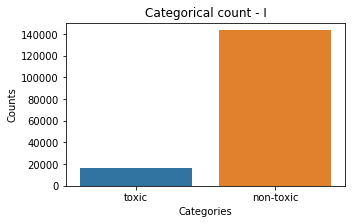

In [6]:
#Code block to visualize the number of total toxic comments of any category and non-toxic comments
train_df["toxicity_score"] = train_df.iloc[:,2:-2].sum(axis=1)
types = ["toxic", "non-toxic"]
toxic_count = len(train_df[train_df["toxicity_score"]>0])
nontoxic_count = train_df.shape[0]-toxic_count
comments_count = [toxic_count, nontoxic_count]

plt.figure(figsize=(5,3))
ax = sns.barplot(types, comments_count)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Categorical count - I')
plt.show()

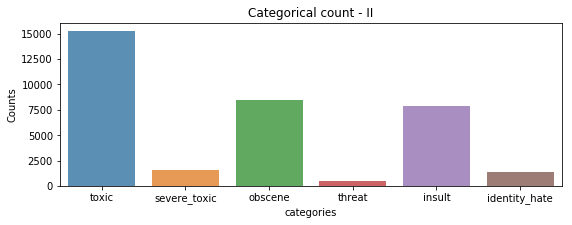

In [7]:
#Code block to visualize the populations of the different categories of toxicity

counts = train_df.iloc[:,2:-2].sum(axis=0)
counts_values = counts.values
categories = counts.index.values

plt.figure(figsize=(9,3))
ax = sns.barplot(categories, counts_values, alpha = 0.8)
plt.xlabel('categories')
plt.ylabel('Counts')
plt.title('Categorical count - II')
plt.show()

We see that a very little section of the entire dataset is actually toxic and that further, the toxic comments are not evenly spread out across the several categories.

## Cleaning


In [8]:
import re, string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
tokenizer=TweetTokenizer()

eng_stopwords = set(stopwords.words("english"))

merge = pd.concat([train_df, test_df])
corpus = merge['comment_text']
def clean(text):
    text = text.lower()
    text = re.sub("\\n","",text) #Removes newlines
    text=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",text) #Removes IP addresses
    text=re.sub("\[\[.*\]","",text) #Removes usernames
    words=tokenizer.tokenize(text) #Tokenization
    words = [w for w in words if not w in eng_stopwords]
    clean_text = " ".join(words)
    return(clean_text)

clean_corpus=corpus.apply(lambda x:clean(x)) #Clean corpus of data for both training and testing combined

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


## Feature Visualization - TFIDF

In [9]:
tf_idf = TfidfVectorizer(min_df = 20, max_features = 100000,
                         analyzer = 'word', ngram_range=(1,1), 
                         use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english', strip_accents = 'unicode')
tfidf_fit = tf_idf.fit(clean_corpus)
features = np.array(tfidf_fit.get_feature_names()) #Get all the features/words that have a corresponding TF-IDF score
train_unigrams =  tfidf_fit.transform(clean_corpus.iloc[:train_df.shape[0]])
test_unigrams = tfidf_fit.transform(clean_corpus.iloc[train_df.shape[0]:])

In [10]:
#Top n tf-idf values in a row 
 
def top_tfidf_features(row, features, top_n = 10):
    topn_ids = np.argsort(row)[::-1][:top_n] # Get indices of the highest top_n features
    top_feats = [(features[i], row[i]) for i in topn_ids] #Get the corresponding feature names
    df = pd.DataFrame(top_feats) 
    df.columns = ['feature', 'tfidf']
    return df

#Top tfidf features in specific comment(matrix row)

def top_feats_in_comment(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

#Top n features that are most important across comments in rows 
def top_mean_features(Xtr, features, grp_ids, min_tfidf=0.1, top_n=10):
    D = Xtr[grp_ids].toarray() #Get an array out of the unigrams
    D[D < min_tfidf] = 0 #Threshold for minimum tf-idf score
    tfidf_means = np.mean(D, axis=0) #Mean of all tf-idf values
    return top_tfidf_features(tfidf_means, features, top_n) 

#List of dataframes that holds top n features and the tfidf value calculated across documents/comments of the same label.
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=10):
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        #feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [11]:
train_tags = train_df.iloc[:,2:-2] #All the scores for different categories
tfidf_top_n_per_class = top_feats_by_class(train_unigrams, features) 

In [12]:
#List top tf-idf features for the nth comment in the training set
top_tfidf_features(np.squeeze(train_unigrams[54].toarray()),features,20)

,feature,tfidf
0,disregard,0.568049
1,awesome,0.512942
2,notice,0.368419
3,simply,0.339507
4,ll,0.308600
5,thanks,0.260728
6,exercising,0.000000
7,exemplified,0.000000
8,exemplifies,0.000000
9,exempt,0.000000


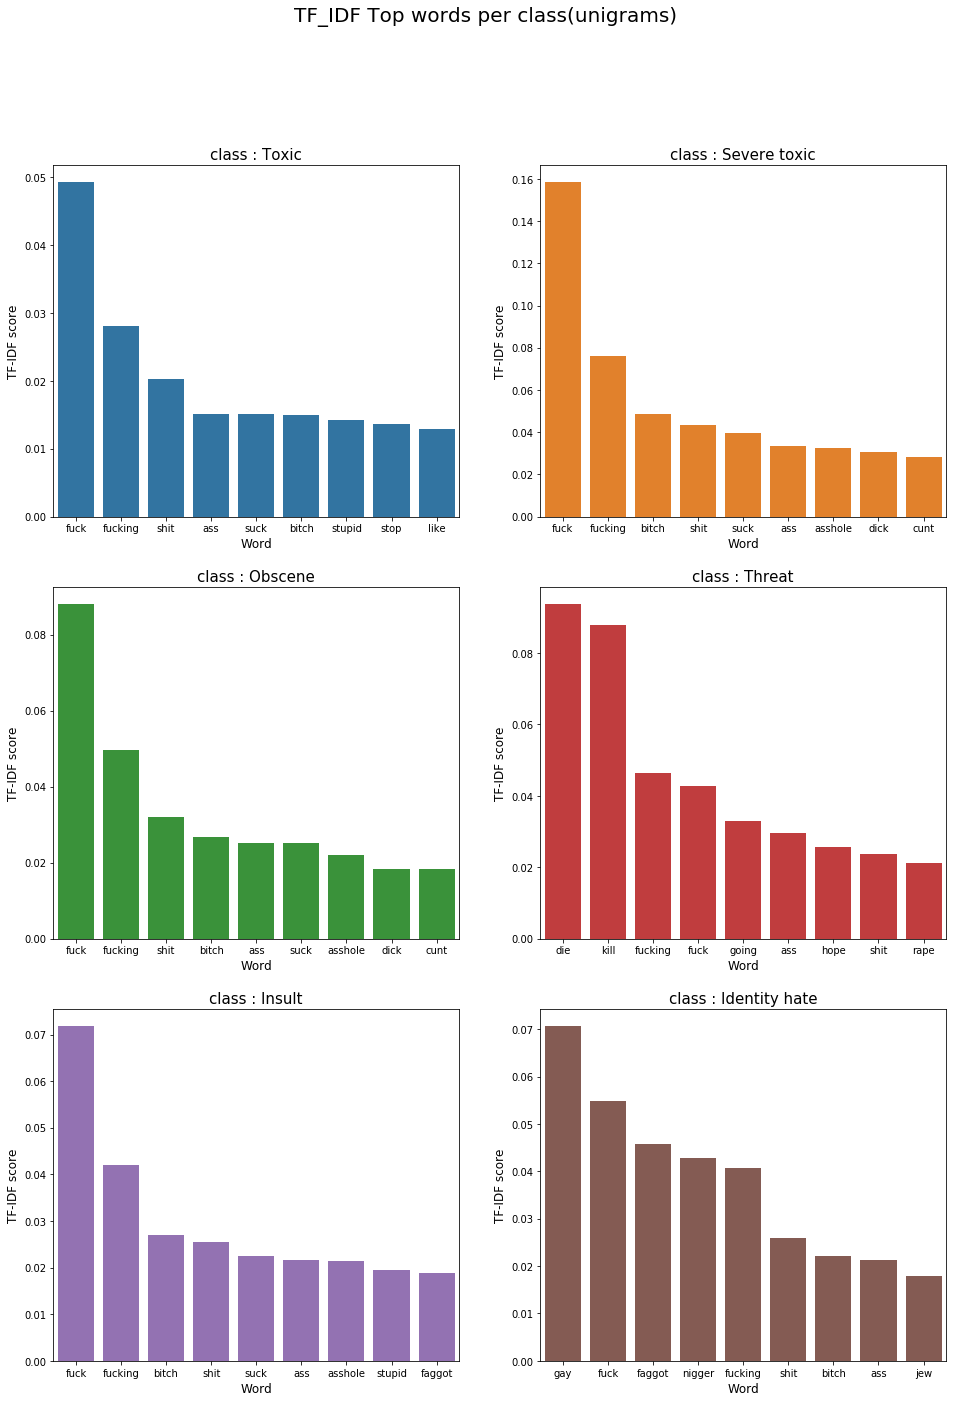

In [13]:
import matplotlib.gridspec as gridspec 
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
color = sns.color_palette()

gridspec.GridSpec(3,2)
plt.subplot2grid((3,2),(0,0))
sns.barplot(tfidf_top_n_per_class[0].feature.iloc[0:9],tfidf_top_n_per_class[0].tfidf.iloc[0:9],color=color[0])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(tfidf_top_n_per_class[1].feature.iloc[0:9],tfidf_top_n_per_class[1].tfidf.iloc[0:9],color=color[1])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((3,2),(1,0))
sns.barplot(tfidf_top_n_per_class[2].feature.iloc[0:9],tfidf_top_n_per_class[2].tfidf.iloc[0:9],color=color[2])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((3,2),(1,1))
sns.barplot(tfidf_top_n_per_class[3].feature.iloc[0:9],tfidf_top_n_per_class[3].tfidf.iloc[0:9],color=color[3])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(tfidf_top_n_per_class[4].feature.iloc[0:9],tfidf_top_n_per_class[4].tfidf.iloc[0:9],color=color[4])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(tfidf_top_n_per_class[5].feature.iloc[0:9],tfidf_top_n_per_class[5].tfidf.iloc[0:9],color=color[5])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

## Adversarial Validation


We will be predicting if an individual comment is from the training set or the testing set. It is the idea to check the degree of similarity between training and test datasets in terms of feature distributions. If they are difficult to distinguish, the distribution is probably similar and the normal validation techniques should work

In [14]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

#Assigning Value 1 to Training Set and 0 to Testing Set
train['is_train']=1
test['is_train']=0
merge = pd.concat([train, test])
merge.drop(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'id'], axis=1, inplace=True)
merge.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,comment_text,is_train
0,Explanation\nWhy the edits made under my usern...,1
1,D'aww! He matches this background colour I'm s...,1
2,"Hey man, I'm really not trying to edit war. It...",1
3,"""\nMore\nI can't make any real suggestions on ...",1
4,"You, sir, are my hero. Any chance you remember...",1


In [15]:
X_train, X_test, y_train, y_valid = train_test_split(merge, merge['is_train'], test_size=0.2, random_state=14) 
print(X_train.shape)
print(X_test.shape)

(250188, 2)
(62547, 2)


In [16]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,4), #4-gram
                            analyzer = 'word', 
                            stop_words=None,
                            max_features = 20000,
                            binary=True)
train_tfidf = tfidf_vec.fit_transform(X_train['comment_text'])
test_tfidf = tfidf_vec.transform(X_test['comment_text'])
print(train_tfidf.shape)
print(test_tfidf.shape)

(250188, 20000)
(62547, 20000)


In [17]:
model = LogisticRegression(solver='newton-cg') #Simple classification
model.fit(train_tfidf, y_train)
pred_test_y = model.predict_proba(test_tfidf)[:, 1]
print('AUC of guessing test: {}'.format(roc_auc_score(y_valid, pred_test_y)))  

AUC of guessing test: 0.6815982623002828


In [ ]:
import eli5

X_test['pred'] = pred_test_y
X_test.head()

eli5.show_weights(model, vec = tfidf_vec, top=30)